# Norwegian Pension Fund Global (GPFG) – Data Preprocessing & Feature Engineering (2024)

This notebook prepares the dataset for downstream machine learning and analytical tasks. Starting from the cleaned 2024 equity holdings dataset, it applies transformations, scaling, feature construction, and data quality checks to ensure the variables are suitable for statistical modeling.

The preprocessing focuses on ownership structure, portfolio distribution, and sustainability dimensions, including the addition of a binary ESG variable derived from raw engagement information.

Scope of This Notebook
This notebook works exclusively with the 2024 equities dataset. Historical data is not included here since preprocessing is focused on model-ready features rather than temporal analysis.


## Preprocessing Objectives

- Variable Standardization & Compatibility

- Ensure numeric columns are correctly typed, stripped of formatting, and fully comparable across observations.

- Remove columns that do not add value.

- Treatment of outliers

- One-hot encoding in categorical variables.

- Final product will be a dataset ready for machine learning techniques to be applied.

## ESG dataset

A new dataset will be imported and used in this notebook, alongside with the final dataset of the first notebook. The process is shown in this notebook.

## Feature Engineering: ESG Dimension

Construct ESG_any, a binary feature indicating whether a holding has documented ESG engagement.

Preserve categorical and textual fields related to ESG for later NLP or multi-class analyses, without synthesizing missing data.

Handling Skewed Distributions.

Apply transformations if needed.



# About the datasets used in this notebook:

## 2024 Holdings Dataset (´fund_2024´)
The dataset `fund_2024` focuses on the **fund's equity holdings in 2024**, providing detailed information on each company including industry, region, country, market value, voting rights, ownership, and portfolio weight. 

**Data Sources & Cleaning:**  
- Original data was obtained from the GPFG official website: [GPFG Investments](https://www.nbim.no/en/investments/all-investments/#/).  
- In this project, the first step was conducted in the notebook named `analysis`, where the dataset `fund_2024` was cleaned and prepared, and an exploratory data analysis was performed. This included renaming columns, calculating portfolio weights, and ensuring consistency across the dataset.


## ESG Engagement Dataset (`esg_2024`)
The dataset `esg_2024` contains companies with whom the fund engaged in dialogues during 2024 on **Environmental, Social, Governance, and Climate Change topics**.  

These dialogues reflect the fund’s **responsible investment strategy**. They are conducted to encourage companies to improve ESG practices, align with sustainability goals, or ensure that long-term risks related to ESG factors are managed appropriately. Being included in this dataset does not imply non-compliance, but rather that the company was a focus of engagement for monitoring and improvement purposes.

The data was sourced from the **annual overview of company dialogues** published by Norges Bank Investment Management: [GPFG Company Dialogues 2024](https://www.nbim.no/en/responsible-investment/engaging-with-companies/annual-overview-of-company-dialogues/).  
- In the original table, an “X” indicated that a dialogue took place.  
- The “X” values were converted to `1`'s in the ESG columns (`Environmental`, `Social`, `Governance`, `Climate_change`) in Excel.  
- Some irrelevant columns were removed, and the cleaned table was then imported into Python as a DataFrame using Pandas.

This dataset provides a **binary indicator for ESG engagement**, enabling analysis of which companies were involved in dialogues and across which ESG topics.


# Setting up and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Set the data path and import datasets
DATA_PATH = "../datasets/"
esg_2024 = pd.read_excel(DATA_PATH +'esg_2024.xlsx')
fund_2024 = pd.read_excel(DATA_PATH +'clean_fund_2024.xlsx')
print(esg_2024.shape)
print(fund_2024.shape) 

(992, 5)
(8645, 8)


In [3]:
esg_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Company         992 non-null    object
 1   Environmental   992 non-null    int64 
 2   Social          992 non-null    int64 
 3   Governance      992 non-null    int64 
 4   Climate change  992 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 38.9+ KB


In [4]:
esg_2024.head(4)

,Company,Environmental,Social,Governance,Climate change
0,3M Co,1,1,1,0
1,A O Smith Corp,1,0,1,1
2,ABB Ltd,1,1,1,1
3,AbbVie Inc,0,1,1,0


In [5]:
#rename columns for clarity, reproducibility and easier merge
esg_2024.rename(columns={'Company':'Name',
                         'Climate change': 'Climate_change'}, inplace=True)
esg_2024.head(2)

,Name,Environmental,Social,Governance,Climate_change
0,3M Co,1,1,1,0
1,A O Smith Corp,1,0,1,1


In [6]:
fund_2024.head(2)

,Industry,Region,Country,Name,Market_Value_USD,Voting,Ownership,Portfolio_Weight
0,Basic Materials,Asia,India,Aarti Industries Ltd,8265429,0.48,0.48,0.000643
1,Basic Materials,Europe,Lithuania,AB Grigeo,2506003,1.75,1.75,0.000195


In [7]:
# Normalize the key field to ensure data integrity during the merge operation
esg_2024['Name'] = esg_2024['Name'].str.lower().str.strip()
fund_2024['Name'] = fund_2024['Name'].str.lower().str.strip()


In [8]:
# Merge datasets
fund_esg_2024 = pd.merge(fund_2024, esg_2024, on='Name', how='left')
print(fund_esg_2024.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8645 entries, 0 to 8644
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Industry          8645 non-null   object 
 1   Region            8645 non-null   object 
 2   Country           8645 non-null   object 
 3   Name              8645 non-null   object 
 4   Market_Value_USD  8645 non-null   int64  
 5   Voting            8645 non-null   float64
 6   Ownership         8645 non-null   float64
 7   Portfolio_Weight  8645 non-null   float64
 8   Environmental     936 non-null    float64
 9   Social            936 non-null    float64
 10  Governance        936 non-null    float64
 11  Climate_change    936 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 810.6+ KB
None


## Note about the merge 
There appears to be an inconsistency in the merge operation: only 936 out of 992 ESG records were successfully matched with the fund’s holdings.
Since the fund dataset uses company names that are expected to be consistent and standardized, this mismatch indicates that an issue occurred during the merging process most likely related to name formatting, hidden characters, or mismatched identifiers.

The next section investigates the source of this discrepancy and explores potential solutions to ensure that all companies with ESG activity are correctly merged.


In [9]:
# Performing an inner merge  to see which ESG companies match exactly 
fund_esg_2024_inner = pd.merge(fund_2024, esg_2024, on='Name', how='inner')
print(fund_esg_2024_inner.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Industry          936 non-null    object 
 1   Region            936 non-null    object 
 2   Country           936 non-null    object 
 3   Name              936 non-null    object 
 4   Market_Value_USD  936 non-null    int64  
 5   Voting            936 non-null    float64
 6   Ownership         936 non-null    float64
 7   Portfolio_Weight  936 non-null    float64
 8   Environmental     936 non-null    int64  
 9   Social            936 non-null    int64  
 10  Governance        936 non-null    int64  
 11  Climate_change    936 non-null    int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 87.9+ KB
None


In [10]:
# Identify ESG companies that did not match the fund portfolio ---
missing_real_esg = esg_2024[~esg_2024['Name'].isin(fund_esg_2024_inner['Name'])]

# Count of missing
print("Number of companies missing in the merge", missing_real_esg.shape[0])

Number of companies missing in the merge 56


In [11]:
#Quick inspection of unmatched companies looking for patterns
missing_real_esg[['Name', 'Environmental']].head(20)


,Name,Environmental
8,acerino1 sa,1
32,ale1andria real estate equities inc,1
47,american e1press co,0
70,argen1 se,0
91,a1a sa,1
92,a1alta coating systems ltd,1
93,a1iata group bhd,0
146,bri1mor property group inc,1
153,b1p inc,1
155,cai1abank sa,0


In [12]:
# Quick look at the companies missing looking for patterns
missing_real_esg.tail(10)

,Name,Environmental,Social,Governance,Climate_change
714,re1ford industrial realty inc,1,0,1,1
718,roblo1 corp,0,1,1,0
728,rt1 corp,1,1,1,1
777,sk hyni1 inc,1,1,1,1
859,te1as instruments inc,0,1,1,0
883,trita1 big bo1 reit plc,0,0,1,0
946,wal-mart de me1ico sab de cv,0,1,1,0
976,1p inc,0,1,1,0
977,1peng inc,1,1,1,1
978,1po inc,0,0,1,0


It appears that all occurrences of '1' in company names have been replaced with 'x', affecting names that originally contained an 'x'.  
To verify this transformation, a test will be conducted: a dataset consisting only of company names containing 'x' from the fund_2024 will be created, and an inner join with the ESG dataset will be performed.  
If the match is perfect, meaning the result has 56 rows corresponding to the previously unmatched companies, the next step will be to re-merge using the transformed names with '1's replaced by 'x'.


In [13]:
# Replace all occurrences of '1' in the Name column with 'x'
missing_replaced = missing_real_esg.copy()
missing_replaced['Name'] = missing_replaced['Name'].str.replace('1', 'x')

#  checking the result of the replacement
missing_replaced[['Name']].head(10)


,Name
8,acerinox sa
32,alexandria real estate equities inc
47,american express co
70,argenx se
91,axa sa
92,axalta coating systems ltd
93,axiata group bhd
146,brixmor property group inc
153,bxp inc
155,caixabank sa


In [14]:
#If the shape is 56 rows, which are the ones missing, the procedure will be correct
test_merge = pd.merge(fund_2024, missing_replaced, on='Name', how='inner')
print("Shape of test merge with replaced 'x':", test_merge.shape)

Shape of test merge with replaced 'x': (56, 12)


In [15]:
# #The test is succesful, proceeds to do the replacement in the esg_2024 dataset and re-merge
esg_2024['Name'] = esg_2024['Name'].str.replace('1', 'x')

In [16]:
#The merge with the corrected names
fund_esg_2024 = pd.merge(fund_2024, esg_2024, on = 'Name', how = 'left')
fund_esg_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8645 entries, 0 to 8644
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Industry          8645 non-null   object 
 1   Region            8645 non-null   object 
 2   Country           8645 non-null   object 
 3   Name              8645 non-null   object 
 4   Market_Value_USD  8645 non-null   int64  
 5   Voting            8645 non-null   float64
 6   Ownership         8645 non-null   float64
 7   Portfolio_Weight  8645 non-null   float64
 8   Environmental     992 non-null    float64
 9   Social            992 non-null    float64
 10  Governance        992 non-null    float64
 11  Climate_change    992 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 810.6+ KB


The merge has been successful: the ESG columns from the ESG dataset have now been fully integrated, resulting in the same number of rows as the ESG dataset. This indicates that all company names in both datasets matched correctly, leaving no missing information.


In [17]:
#Fill the null values in the ESG columns with 0 and convert to integer type, since NaN means no engagement
cols_esg = ['Environmental', 'Social', 'Governance', 'Climate_change']
fund_esg_2024[cols_esg] = fund_esg_2024[cols_esg].fillna(0).astype(int)
fund_esg_2024.info()    


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8645 entries, 0 to 8644
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Industry          8645 non-null   object 
 1   Region            8645 non-null   object 
 2   Country           8645 non-null   object 
 3   Name              8645 non-null   object 
 4   Market_Value_USD  8645 non-null   int64  
 5   Voting            8645 non-null   float64
 6   Ownership         8645 non-null   float64
 7   Portfolio_Weight  8645 non-null   float64
 8   Environmental     8645 non-null   int32  
 9   Social            8645 non-null   int32  
 10  Governance        8645 non-null   int32  
 11  Climate_change    8645 non-null   int32  
dtypes: float64(3), int32(4), int64(1), object(4)
memory usage: 675.5+ KB


In [18]:
# Create a new column 'ESG_any' that indicates if a company has any ESG engagement
fund_esg_2024["ESG_any"] = ((fund_esg_2024[["Environmental","Social","Governance","Climate_change"]].sum(axis=1)) > 0).astype(int)
fund_esg_2024.head(5)

,Industry,Region,Country,Name,Market_Value_USD,Voting,Ownership,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any
0,Basic Materials,Asia,India,aarti industries ltd,8265429,0.48,0.48,0.000643,0,0,0,0,0
1,Basic Materials,Europe,Lithuania,ab grigeo,2506003,1.75,1.75,0.000195,0,0,0,0,0
2,Basic Materials,Europe,Spain,acerinox sa,44222411,1.81,1.81,0.003439,1,1,0,0,1
3,Basic Materials,Asia,Japan,achilles corp,346429,0.26,0.26,0.000027,0,0,0,0,0
4,Basic Materials,North America,Canada,aclara resources inc,93266,0.18,0.18,0.000007,0,0,0,0,0


# Brief Data Exploration


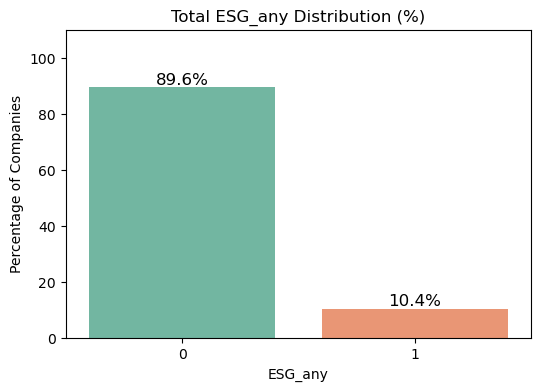

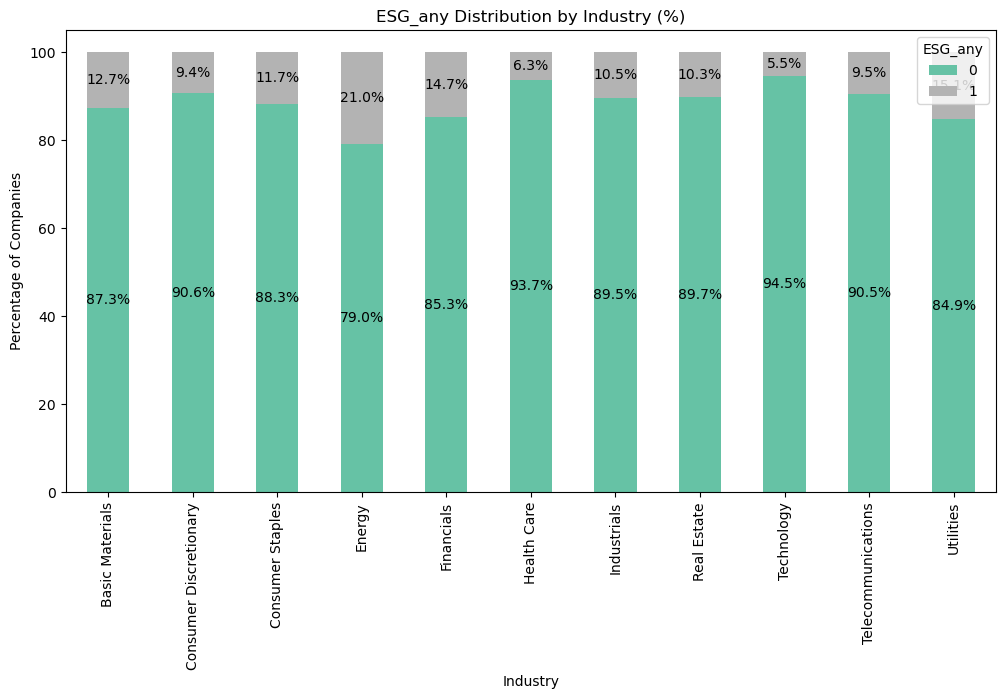

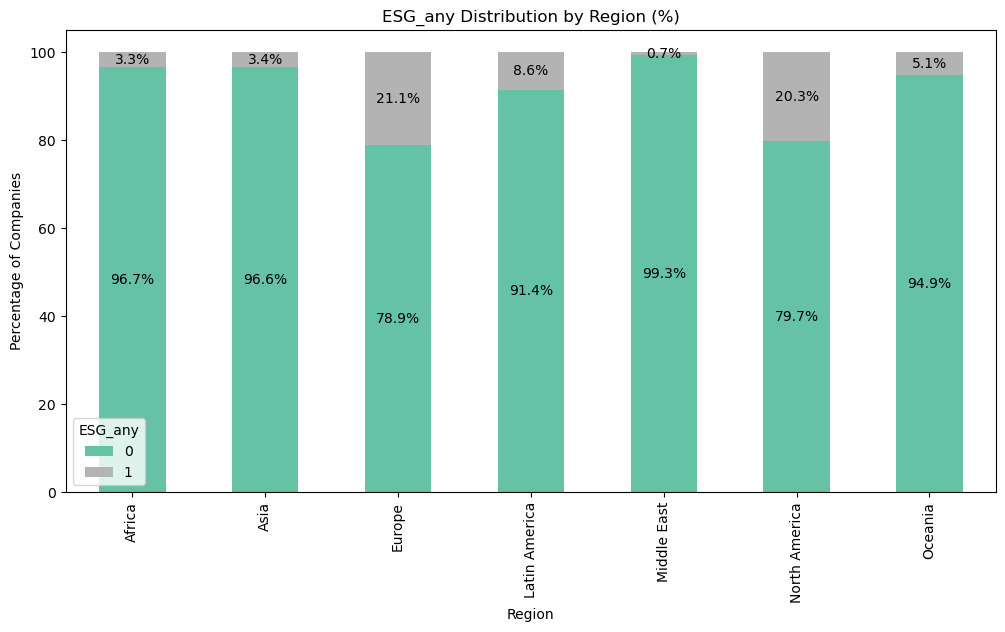

In [19]:
def plot_esg_distribution_percent(df):
    """
    Plots ESG_any distribution as percentages: total, by Industry, and by Region.
    Shows percentages on top of bars.
    """
    # Total 
    total_counts = df['ESG_any'].value_counts(normalize=True) * 100
    plt.figure(figsize=(6,4))
    sns.barplot(x=total_counts.index, y=total_counts.values, palette='Set2')
    for i, v in enumerate(total_counts.values):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=12)
    plt.title('Total ESG_any Distribution (%)')
    plt.xlabel('ESG_any')
    plt.ylabel('Percentage of Companies')
    plt.ylim(0, 110)
    plt.show()

    #  By Industry 
    industry_counts = df.groupby('Industry')['ESG_any'].value_counts(normalize=True).unstack(fill_value=0) * 100
    industry_counts.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set2')
    plt.title('ESG_any Distribution by Industry (%)')
    plt.ylabel('Percentage of Companies')
    plt.xlabel('Industry')
    for i, row in enumerate(industry_counts.values):
        plt.text(i, row[0]/2, f'{row[0]:.1f}%', ha='center', va='center', fontsize=10)
        plt.text(i, row[0] + row[1]/2, f'{row[1]:.1f}%', ha='center', va='center', fontsize=10)
    plt.show()

    #  By Region
    region_counts = df.groupby('Region')['ESG_any'].value_counts(normalize=True).unstack(fill_value=0) * 100
    region_counts.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set2')
    plt.title('ESG_any Distribution by Region (%)')
    plt.ylabel('Percentage of Companies')
    plt.xlabel('Region')
    for i, row in enumerate(region_counts.values):
        plt.text(i, row[0]/2, f'{row[0]:.1f}%', ha='center', va='center', fontsize=10)
        plt.text(i, row[0] + row[1]/2, f'{row[1]:.1f}%', ha='center', va='center', fontsize=10)
    plt.show()

# Usage
plot_esg_distribution_percent(fund_esg_2024)


As shown in the graphs, the industry with the highest percentage of ESG-related engagements is Energy, representing 21% of all companies with ESG issues within its own industry (i.e., percentages are calculated independently for each industry, not cumulatively across industries). It is followed by Financials at 14.7% and Consumer Staples at 11.7%.
For regions, Europe shows the highest share at 21.1% (again, percentages are computed within each region independently), closely followed by North America at 20.3%.

In [20]:
fund_esg_2024[fund_esg_2024['ESG_any'] ==1].value_counts(normalize=True)

Industry         Region         Country        Name                     Market_Value_USD  Voting  Ownership  Portfolio_Weight  Environmental  Social  Governance  Climate_change  ESG_any
Basic Materials  Africa         South Africa   gold fields ltd          169704075         1.45    1.45       0.013198          1              1       0           0               1          0.00111
Industrials      Asia           Japan          omron corp               41970162          0.60    0.60       0.003264          1              1       1           1               1          0.00111
                 Europe         Germany        deutsche post ag         554757710         1.31    1.31       0.043144          1              0       1           1               1          0.00111
                                               heidelberg materials ag  260204434         1.16    1.16       0.020236          1              1       1           1               1          0.00111
                          

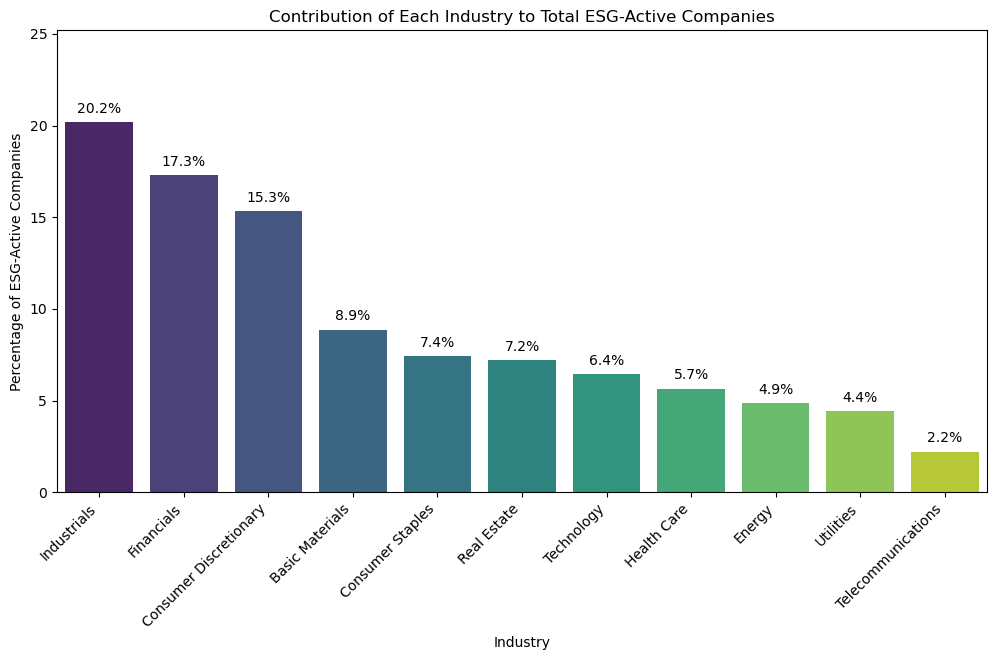

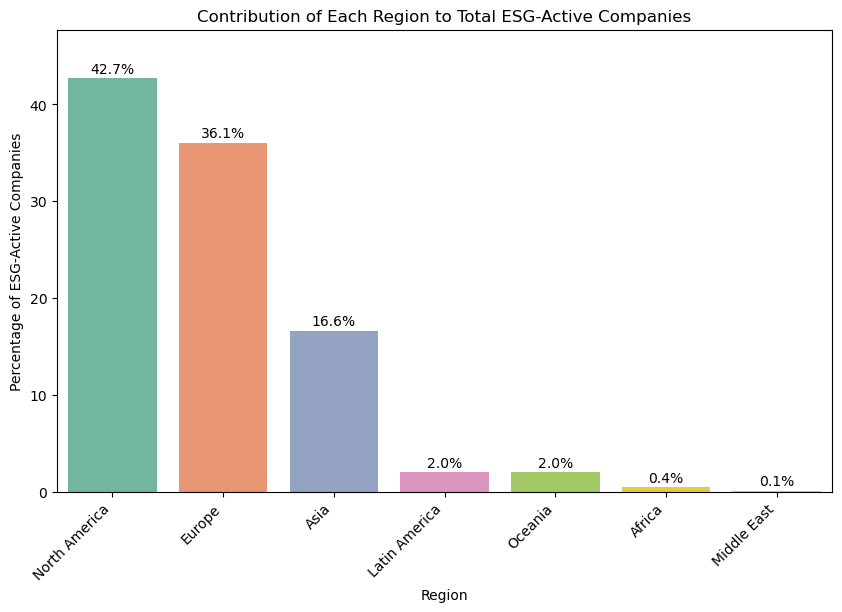

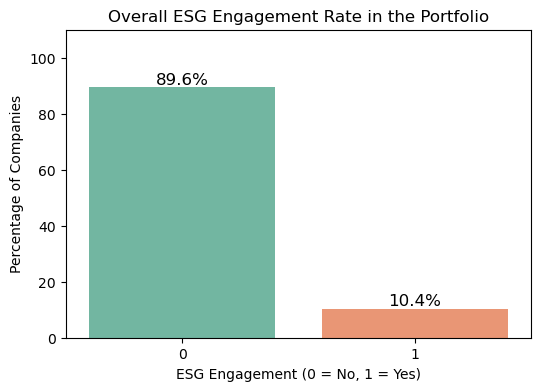

In [21]:
def plot_esg_contribution(df):
    """
    Plots the contribution of each category (Industry, Region) 
    to the total number of ESG-engaged companies (ESG_any = 1).
    """

    # Filter only ESG=1 companies
    df_esg = df[df['ESG_any'] == 1]

    # Total ESG count 
    total_esg = len(df_esg)

    #  Contribution by Industry
    industry_contrib = df_esg['Industry'].value_counts(normalize=True) * 100

    plt.figure(figsize=(12, 6))
    sns.barplot(x=industry_contrib.index, y=industry_contrib.values, palette="viridis")
    plt.xticks(rotation=45, ha='right')
    plt.title('Contribution of Each Industry to Total ESG-Active Companies')
    plt.ylabel('Percentage of ESG-Active Companies')
    plt.xlabel('Industry')

    for i, v in enumerate(industry_contrib.values):
        plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10)

    plt.ylim(0, industry_contrib.max() + 5)
    plt.show()


    # --- Contribution by Region ---
    region_contrib = df_esg['Region'].value_counts(normalize=True) * 100

    plt.figure(figsize=(10, 6))
    sns.barplot(x=region_contrib.index, y=region_contrib.values, palette="Set2")
    plt.xticks(rotation=45, ha='right')
    plt.title('Contribution of Each Region to Total ESG-Active Companies')
    plt.ylabel('Percentage of ESG-Active Companies')
    plt.xlabel('Region')

    for i, v in enumerate(region_contrib.values):
        plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10)

    plt.ylim(0, region_contrib.max() + 5)
    plt.show()


    # --- Total ESG_any distribution (simple) ---
    total_counts = df['ESG_any'].value_counts(normalize=True) * 100

    plt.figure(figsize=(6, 4))
    sns.barplot(x=total_counts.index, y=total_counts.values, palette="Set2")
    plt.title('Overall ESG Engagement Rate in the Portfolio')
    plt.ylabel('Percentage of Companies')
    plt.xlabel('ESG Engagement (0 = No, 1 = Yes)')

    for i, v in enumerate(total_counts.values):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=12)

    plt.ylim(0, 110)
    plt.show()


# Usage
plot_esg_contribution(fund_esg_2024)


The Industrials and Financials sectors contribute the largest shares of companies involved in ESG-related dialogues, representing 20.2% and 17.3% of all cases, respectively. The prominence of Industrials is not surprising, since the core activities of this sector involve transforming raw materials, operating large supply chains, and managing processes that often carry environmental and social externalities.

The position of Financials is more structurally interesting: even though financial institutions do not produce physical goods, they exert significant influence through capital allocation and risk management. As a result, the GPFG often engages with this sector on topics such as governance quality, responsible lending, transparency, and oversight of financed emissions.

Regarding regions, North America and Europe account for 42.7% and 36.1% of all ESG dialogues in 2024. This distribution likely reflects multiple structural factors: both regions represent a large portion of the fund’s equity holdings, have higher disclosure standards, and maintain more developed frameworks for stewardship and active ownership. In contrast, companies in some Asian markets may exhibit lower transparency levels or different engagement practices, which could reduce the frequency of formal ESG dialogues recorded by the fund.

# Preprocessing

## Encoding variables
explicacion de por qué SMOTE NO y cuál estrategia se usará
hacer autoML pero igual Gradient Boosting / XGBoost / LightGBM / CatBoost sirven más para clases desbalanceadas y usar SHAP para interpretar cada feature. Random Forest también. Se hace un ciclo for o AutoML con LazyPredict. PEro primero se hace la de statsmodel, y se contrastan ambas

Sin usar accuracy sino otras metrics como la curva roc o f1

Scaler:
- Market Value: MinMaxScaler
- Busca un ejemplo de mapping personalizado con dict para hacerlo en industry y en region
- NAME se va, porque no aporta nada explicativo.

import shap
import xgboost as xgb

# Example
model = xgb.XGBClassifier(scale_pos_weight=10, random_state=42)
model.fit(X_train_encoded, y_train)

explainer = shap.Explainer(model, X_train_encoded)
shap_values = explainer(X_test_encoded)

# Summary plot
shap.summary_plot(shap_values, X_test_encoded)


haz auto ML o haz regression de statsmodel
recuerda hacer class_weights='balanced' cuando actives el modelo tipo clf = LogisticRegression(class_weight='balanced', random_state=42)

Name: se va
Region e Industry: OneHot
MarketValue: MinMax
Country: parace q c va
Portfolio_Weight: toca normalizarla o algo así

In [22]:
# Prepare final dataset for ML modeling
ml_df = fund_esg_2024.copy()

In [23]:
ml_df.head(2)

,Industry,Region,Country,Name,Market_Value_USD,Voting,Ownership,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any
0,Basic Materials,Asia,India,aarti industries ltd,8265429,0.48,0.48,0.000643,0,0,0,0,0
1,Basic Materials,Europe,Lithuania,ab grigeo,2506003,1.75,1.75,0.000195,0,0,0,0,0


`Name` is a unique identifier for each company and does not carry generalizable information, so encoding it would lead to overfitting rather than providing meaningful features for the model.

In [24]:
# Delete the Name column as it is not needed for modeling
ml_df.drop(columns=['Name'], inplace=True)
ml_df.head(3)

,Industry,Region,Country,Market_Value_USD,Voting,Ownership,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any
0,Basic Materials,Asia,India,8265429,0.48,0.48,0.000643,0,0,0,0,0
1,Basic Materials,Europe,Lithuania,2506003,1.75,1.75,0.000195,0,0,0,0,0
2,Basic Materials,Europe,Spain,44222411,1.81,1.81,0.003439,1,1,0,0,1


Let's take a look to the correlation of the numeric variables. If two variables are higly correlated, it'll mean they contain basically the same information, and since there are in the dataset the variables `Ownership` and `Voting`,  which by its nature tend to be correlated, let's check it and then act

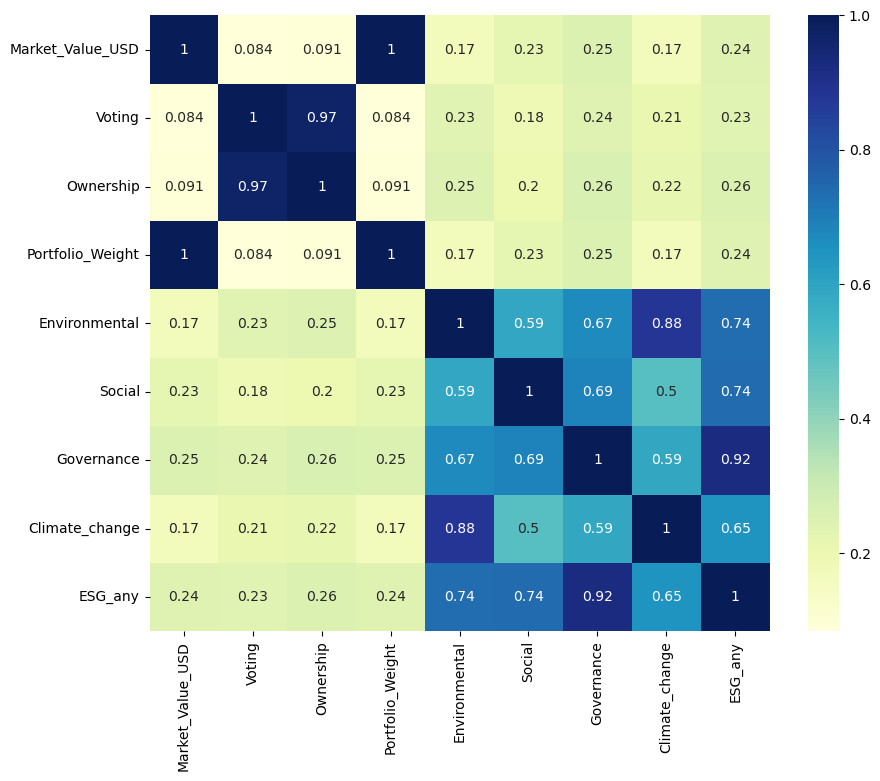

In [25]:
#Compute the correlations only with numeric columns
df_corr = ml_df.corr(numeric_only=True)

plt.figure(figsize=(10,8))

#Show the correlations in a heatmap
sns.heatmap(data = df_corr, cmap = 'YlGnBu', annot=True)

plt.show()

**Correlation Assessment of Numerical Variables**

A correlation matrix was computed to assess the degree of linear association among numerical variables in the dataset. High correlation between features may indicate redundant information, potentially affecting model interpretability and contributing to multicollinearity in regression-based methods.

A particularly strong correlation is observed between the variables `Ownership` and `Voting` Voting (~ 0.97). This magnitude suggests that both variables encode substantially overlapping information regarding exposure to a company. For modeling purposes, retaining both would not add meaningful explanatory power while introducing redundant inputs. Given that economic exposure is more fundamental to the investment structure than voting records, only Ownership will be retained in the machine-learning pipeline, while Voting will be removed.

Regarding the environmental, social, and governance indicators, moderate-to-high correlations are expected because these variables describe related aspects of corporate sustainability practices. The variable ESG_any is, by construction, strongly correlated with the other three ESG columns. Despite these associations and high values, each dimension represents a distinct attribute of the fund’s stewardship decisions and remains conceptually relevant. Therefore, no exclusion will be performed on ESG-related variables, as their correlations reflect thematic alignment rather than duplication.





In [26]:
ml_df.head(2)

,Industry,Region,Country,Market_Value_USD,Voting,Ownership,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any
0,Basic Materials,Asia,India,8265429,0.48,0.48,0.000643,0,0,0,0,0
1,Basic Materials,Europe,Lithuania,2506003,1.75,1.75,0.000195,0,0,0,0,0


In [27]:
# Eliminate Voting due to high correlation with Ownership
ml_df.drop(columns=['Voting'], inplace=True)
#Check
ml_df.head(2)

,Industry,Region,Country,Market_Value_USD,Ownership,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any
0,Basic Materials,Asia,India,8265429,0.48,0.000643,0,0,0,0,0
1,Basic Materials,Europe,Lithuania,2506003,1.75,0.000195,0,0,0,0,0


In [28]:
# Checking unique values in categorical columns
columns = ['Region', 'Industry', 'Country']
for col in columns:
    print(f'Number of unique values in {col}: {ml_df[col].nunique()}')




Number of unique values in Region: 7
Number of unique values in Industry: 11
Number of unique values in Country: 63


One-Hot Encoding was chosen for the 'Industry' and 'Region' columns because both are categorical variables **without a natural order**.  
This approach avoids introducing artificial numeric relationships and ensures that each category is represented explicitly, which is compatible with a wide range of machine learning models and keeps interpretability clear.  
Given that 'Industry' has 11 categories and 'Region' has 6, the number of resulting columns is manageable and does not overload the dataset.


In [29]:
pd.set_option('display.max_columns', None) # Show all columns, useful for checking one-hot encoding

In [30]:
def one_hot_encode(df, columns):
    """
    One-Hot Encode the specified categorical columns in a dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe
    columns (list): List of categorical columns to encode

    Returns:
    pd.DataFrame: DataFrame with one-hot encoded columns
    """
    for col in columns:
        # Create temporary one-hot encoded columns for the current categorical column
        # The new columns are prefixed with the original column name
        dummies = pd.get_dummies(df[col], prefix=col)

        #  Convert boolean columns to integers (0/1)
        dummies = dummies.astype(int)

        # Concatenate the new dummy columns horizontally to the original dataframe
        # axis=1 ensures we are adding columns, not rows
        df = pd.concat([df, dummies], axis=1)

        # Drop the original categorical column, since it is now represented by the dummy columns
        #    axis=1 specifies that we're dropping
        df.drop(col, axis=1, inplace=True)

    return df


In [31]:
ml_df = one_hot_encode(ml_df, columns= ['Region', 'Industry'])

In [32]:
# Show the result
ml_df.sample(2)

,Country,Market_Value_USD,Ownership,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any,Region_Africa,Region_Asia,Region_Europe,Region_Latin America,Region_Middle East,Region_North America,Region_Oceania,Industry_Basic Materials,Industry_Consumer Discretionary,Industry_Consumer Staples,Industry_Energy,Industry_Financials,Industry_Health Care,Industry_Industrials,Industry_Real Estate,Industry_Technology,Industry_Telecommunications,Industry_Utilities
3707,United States,890390,0.04,0.000069,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
7677,United States,6346333,0.28,0.000494,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


The column `Country` will be removed from the dataset because:

- There are 63 unique countries, but the distribution of companies by country is very uneven, as shown in the EDA dataset, the first step of this project.

- Most of the information about geographic location is already captured by the `Region` column.

- Keeping `Country` would unnecessarily increase dimensionality without adding meaningful information for ML.


In [33]:
# Drop Country column
ml_df = ml_df.drop(columns=['Country'])
ml_df.head(1)

,Market_Value_USD,Ownership,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any,Region_Africa,Region_Asia,Region_Europe,Region_Latin America,Region_Middle East,Region_North America,Region_Oceania,Industry_Basic Materials,Industry_Consumer Discretionary,Industry_Consumer Staples,Industry_Energy,Industry_Financials,Industry_Health Care,Industry_Industrials,Industry_Real Estate,Industry_Technology,Industry_Telecommunications,Industry_Utilities
0,8265429,0.48,0.000643,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [34]:
ml_df['Market_Value_USD'].min()

1

In [35]:
ml_df['Market_Value_USD'].max()

46210392003

In [36]:
ml_df.shape

(8645, 26)

In [37]:
ml_df['Ownership'].min()

0.0

In [38]:
ml_df[ml_df['Ownership'] == ml_df['Ownership'].min()]

,Market_Value_USD,Ownership,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any,Region_Africa,Region_Asia,Region_Europe,Region_Latin America,Region_Middle East,Region_North America,Region_Oceania,Industry_Basic Materials,Industry_Consumer Discretionary,Industry_Consumer Staples,Industry_Energy,Industry_Financials,Industry_Health Care,Industry_Industrials,Industry_Real Estate,Industry_Technology,Industry_Telecommunications,Industry_Utilities
85,112547,0.0,8.752779e-06,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
113,711,0.0,5.529446e-08,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
118,6025,0.0,4.685642e-07,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
155,108702,0.0,8.453753e-06,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
156,2,0.0,1.555400e-10,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8488,1656,0.0,1.287871e-07,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8527,394,0.0,3.064138e-08,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8574,953,0.0,7.411480e-08,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8629,334255,0.0,2.599501e-05,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


**Treatment of rows with `Ownership = 0`**

 As shown on the cell above, there are 276 cases (roughly 3% of the total observations) where the fund reports `Ownership = 0` while the `Voting` field is non-zero (that is the reason why it is part of the dataset). This is an unusual combination and can arise for several reasons, including:
- Different share classes where the fund has voting rights on certain shares but no direct economic ownership reflected in the `Ownership` field;    
- Aggregation or timing mismatches between the ownership snapshot and the voting records.

This project is interested in companies in which the fund holds any ownership. Therefore, to avoid introducing noise or misleading signals in the machine-learning pipeline, we will remove rows where `Ownership == 0`. 

In [39]:
# Creating a mask to filter rows where Ownership is 0 and re-counting them
mask = (ml_df['Ownership']== 0)
ml_df[mask].shape

(276, 26)

In [40]:
# Shape before removing rows with Ownership = 0
ml_df.shape

(8645, 26)

In [41]:
# Removing rows where Ownership is 0
ml_df = ml_df[ml_df['Ownership'] != 0]

#Shape has to be 8369 rows now
ml_df.shape

(8369, 26)

In [42]:
# Looking into the columns Portfolio_Weight, Ownership
cols = ['Portfolio_Weight', 'Ownership']
for col in ml_df[cols]:
    print(f'The minimum value of the {col} is : {ml_df[col].min()}')
    print(f'The maximum value of the {col} is : {ml_df[col].max()}')
    print(f'The total sum of the {col} is : {ml_df[col].sum()}')


The minimum value of the Portfolio_Weight is : 7.776998971316522e-11
The maximum value of the Portfolio_Weight is : 3.593781710714642
The total sum of the Portfolio_Weight is : 99.99798002732912
The minimum value of the Ownership is : 0.01
The maximum value of the Ownership is : 25.19
The total sum of the Ownership is : 9045.159999999998


In [ ]:
import plotly.express as px

columns = ['Portfolio_Weight', 'Ownership', 'Market_Value_USD']
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]

# Dictionary to save percentile data
data = {col: [ml_df[col].quantile(p/100) for p in percentiles] for col in columns}

# Create DataFrame of percentiles
percentiles_df = pd.DataFrame(data, index=[f'{p}%' for p in percentiles])

# Reset index for converting percentiles into a column for easier plotting
percentiles_plot_df = percentiles_df.reset_index().rename(columns={'index': 'Percentile'})

#Converting the Percentile column to int (removing the %)
percentiles_plot_df['Percentile'] = percentiles_plot_df['Percentile'].str.rstrip('%').astype(int)

# Converting from wide to long format for plotly
percentiles_long = percentiles_plot_df.melt(id_vars='Percentile', 
                                            value_vars=columns, 
                                            var_name='Variable', 
                                            value_name='Value')

# Plotting
fig = px.line(percentiles_long, x='Percentile', y='Value', color='Variable', 
              markers=True, title='Distribution of Numeric Columns by Percentiles')

fig.update_layout(yaxis_type='log',  # Log para ver mejor los valores muy pequeños
                  xaxis_title='Percentile',
                  yaxis_title='Value (log scale)',
                  template='plotly_white')

fig.show()


**Skewed Distributions and Power-Law Behavior**

The numeric variables (`Portfolio_Weight`, `Ownership`, `Market_Value_USD`) exhibit a highly skewed distribution, where a few holdings account for a large portion of the total. This pattern is typical in large equity portfolios and is often described as a **power-law distribution**.

**Why this matters for ML:**
- Raw values are concentrated among a few companies, while the majority of holdings have very small weights.
- Without transformation, models may focus disproportionately on the largest holdings and ignore patterns across smaller ones.

**Solution:**  
Applying a **log-transformation** followed by **MinMax scaling** spreads the values more evenly, allowing the model to detect patterns across all scales without losing signal from the smaller holdings.


**Scaling Strategy for Numeric Variables**

The three main numeric variables (`Portfolio_Weight`, `Ownership`, `Market_Value_USD`) have different scales and skewness:

1. **Portfolio_Weight**  
   - Highly skewed, most holdings are very small; a few dominate the portfolio.  
   - **Log transformation** spreads the small values for better visibility.  
   - **MinMax scaling** normalizes between 0 and 1 for consistent input to ML models.

2. **Ownership**  
   - Skewed distribution, concentrated among a few holdings.  
   - **Log transformation** reduces extreme differences while keeping relative proportions.  
   - **MinMax scaling** ensures all values are on the same scale as other features.

3. **Market_Value_USD**  
   - Wide range.  
   - **Log transformation** compresses large differences, capturing patterns across all holdings.  
   - **MinMax scaling** standardizes the variable for model input without losing the underlying distribution.

**Summary:**  
Log transformation corrects skewness and handles extreme concentrations, while MinMax scaling ensures all numeric features are comparable, improving ML model stability and learning across the full range of values.


In [44]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

columns = ['Portfolio_Weight', 'Ownership', 'Market_Value_USD']

for col in ml_df[columns]:
    # Apply log transformation to compress the scale
    ml_df[f'{col}_log'] = np.log1p(ml_df[col])  # log1p to handle zero values safely

In [45]:
#Quick view of the transformed data
ml_df[2:3]

,Market_Value_USD,Ownership,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any,Region_Africa,Region_Asia,Region_Europe,Region_Latin America,Region_Middle East,Region_North America,Region_Oceania,Industry_Basic Materials,Industry_Consumer Discretionary,Industry_Consumer Staples,Industry_Energy,Industry_Financials,Industry_Health Care,Industry_Industrials,Industry_Real Estate,Industry_Technology,Industry_Telecommunications,Industry_Utilities,Portfolio_Weight_log,Ownership_log,Market_Value_USD_log
2,44222411,1.81,0.003439,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.003433,1.033184,17.604742


In [46]:
columns_log = [f'{col}_log' for col in ['Portfolio_Weight', 'Ownership', 'Market_Value_USD']]

# Checking if log transformation worked as expected
for col in columns_log:
    print(f"\n- Checking {col} -")
    
    # Verify negative values
    if (ml_df[col] < 0).any():
        print("Negative values detected!")
    else:
        print("No negative values detected")
    



- Checking Portfolio_Weight_log -
No negative values detected

- Checking Ownership_log -
No negative values detected

- Checking Market_Value_USD_log -
No negative values detected


In [47]:
#It went well, therefore, time to proceed with scaling
for col in ml_df[columns_log]:
    ml_df[f'{col}_scaled']= scaler.fit_transform(ml_df[[col]])
    

In [48]:
# Overview of the scaled columns
ml_df.sample(1)

,Market_Value_USD,Ownership,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any,Region_Africa,Region_Asia,Region_Europe,Region_Latin America,Region_Middle East,Region_North America,Region_Oceania,Industry_Basic Materials,Industry_Consumer Discretionary,Industry_Consumer Staples,Industry_Energy,Industry_Financials,Industry_Health Care,Industry_Industrials,Industry_Real Estate,Industry_Technology,Industry_Telecommunications,Industry_Utilities,Portfolio_Weight_log,Ownership_log,Market_Value_USD_log,Portfolio_Weight_log_scaled,Ownership_log_scaled,Market_Value_USD_log_scaled
7436,226518890,1.52,0.017616,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.017463,0.924259,19.238339,0.011453,0.280857,0.777142



--- Checking Portfolio_Weight ---
Min: 0.000000, Max: 3.593782


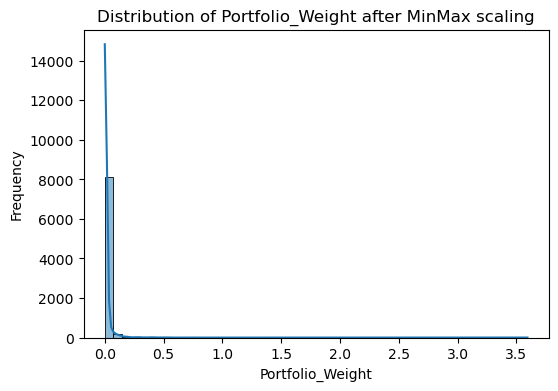


--- Checking Ownership ---
Min: 0.010000, Max: 25.190000


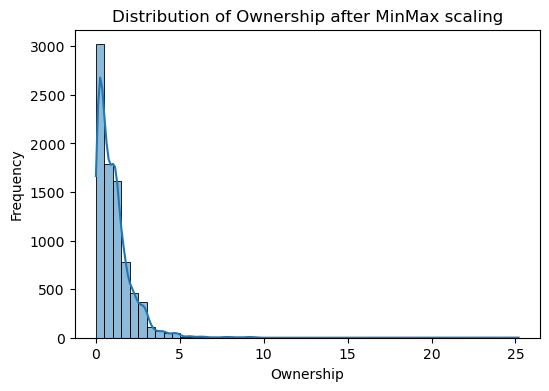


--- Checking Market_Value_USD ---
Min: 1.000000, Max: 46210392003.000000


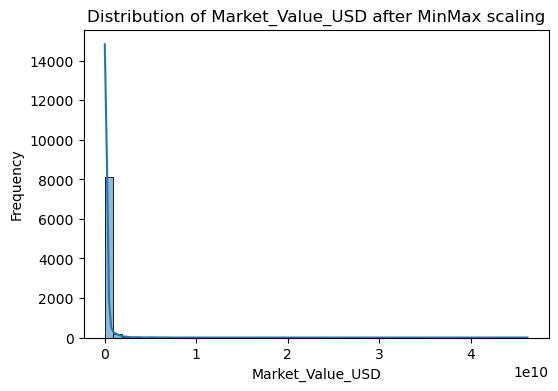

In [49]:
# Checkign how effective the scaling was
#First, look at the distribution of the scaled columns before and after scaling
columns_scaled = [f'{col}' for col in columns]

for col in columns_scaled:
    print(f"\n--- Checking {col} ---")
    
    # Veryfy range 0-1
    print(f"Min: {ml_df[col].min():.6f}, Max: {ml_df[col].max():.6f}")
    
    # Distribution plot
    plt.figure(figsize=(6,4))
    sns.histplot(ml_df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col} after MinMax scaling')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()



 Checking Portfolio_Weight_log_scaled 
Min: 0.000000, Max: 1.000000


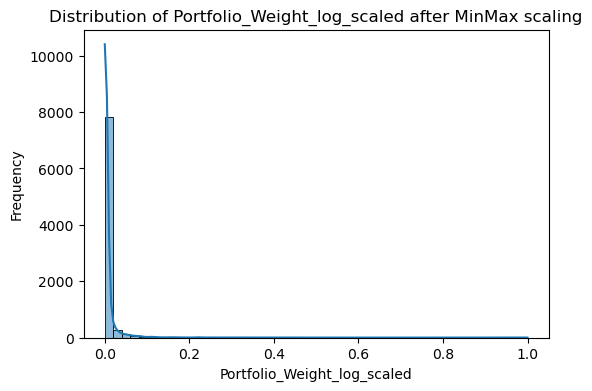


 Checking Ownership_log_scaled 
Min: 0.000000, Max: 1.000000


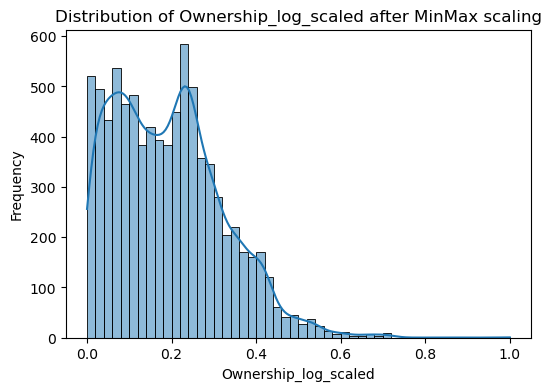


 Checking Market_Value_USD_log_scaled 
Min: 0.000000, Max: 1.000000


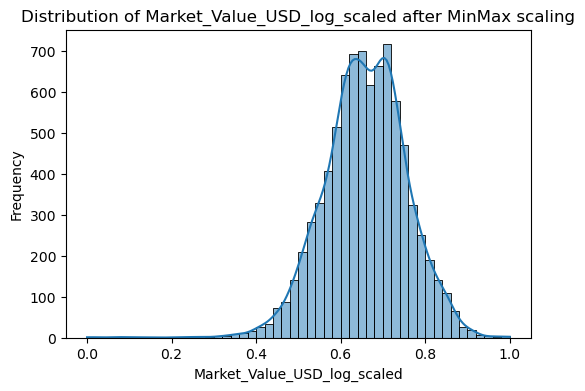

In [50]:
# Scaled  data verification
columns_scaled = [f'{col}_scaled' for col in columns_log]

for col in columns_scaled:
    print(f"\n Checking {col} ")
    
    #  Verifying range 0-1
    print(f"Min: {ml_df[col].min():.6f}, Max: {ml_df[col].max():.6f}")
    
    # See the distribution
    plt.figure(figsize=(6,4))
    sns.histplot(ml_df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col} after MinMax scaling')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()



In [51]:
ml_df.sample(2)

,Market_Value_USD,Ownership,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any,Region_Africa,Region_Asia,Region_Europe,Region_Latin America,Region_Middle East,Region_North America,Region_Oceania,Industry_Basic Materials,Industry_Consumer Discretionary,Industry_Consumer Staples,Industry_Energy,Industry_Financials,Industry_Health Care,Industry_Industrials,Industry_Real Estate,Industry_Technology,Industry_Telecommunications,Industry_Utilities,Portfolio_Weight_log,Ownership_log,Market_Value_USD_log,Portfolio_Weight_log_scaled,Ownership_log_scaled,Market_Value_USD_log_scaled
6794,175923,0.06,0.000014,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000014,0.058269,12.077807,0.000009,0.014842,0.477078
4132,2120763,1.94,0.000165,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0.000165,1.078410,14.567287,0.000108,0.328209,0.581400


In [52]:
# Quick look at the ESG columns averages
ml_df[["Environmental","Social","Governance","Climate_change","ESG_any"]].mean()


Environmental     0.061417
Social            0.061895
Governance        0.092843
Climate_change    0.048154
ESG_any           0.107181
dtype: float64

In [53]:
# This will help to understand the skewness of the distributions
from scipy.stats import skew

for col in ["Portfolio_Weight", "Portfolio_Weight_log", "Portfolio_Weight_log_scaled",
            "Ownership", "Ownership_log", "Ownership_log_scaled",
            "Market_Value_USD", "Market_Value_USD_log", "Market_Value_USD_log_scaled"]:
    print(col, skew(ml_df[col]))


Portfolio_Weight 28.908374147306837
Portfolio_Weight_log 17.53062378173765
Portfolio_Weight_log_scaled 17.530623781737642
Ownership 3.657526735620883
Ownership_log 0.674345129781324
Ownership_log_scaled 0.6743451297813232
Market_Value_USD 28.90837414730683
Market_Value_USD_log -0.3232807817632987
Market_Value_USD_log_scaled -0.32328078176329805


**Why Skewnnes Matters for Machine Learning:**

Extreme skew can cause models to assign disproportionate importance to a small set of extreme values rather than learning generalizable patterns.
Log transformation expands differences among small observations that would otherwise be numerically indistinguishable.
Min-Max scaling ensures features fall within comparable numerical ranges, which is particularly important for models based on gradient optimization, distance metrics, and regularization.

- **Portfolio_Weight:**

This variable remains highly right-skewed even after transformations (skew decreases from approximately 29 to approximately 17). The limited reduction reflects the structural nature of capital concentration in market-cap-weighted global portfolios: a small number of positions dominate total exposure, while the majority are extremely small allocations.

This is expected behavior in financial portfolios and does not indicate a preprocessing issue. The extreme skew conveys essential economic information: concentration is a feature of the system, not noise. Applying a log transform would distort relative magnitudes among small weights without meaningfully improving distributional balance.

Final decision: apply Min-Max scaling directly to raw values. This approach maintains compatibility with ML models while preserving the underlying economic structure, where relative scale and extreme concentration carry explanatory value.





- **Ownership:**

Initially moderately right-skewed (skew ~ 3.61). After log transformation, skew reduces to approximately 0.65. This improves numerical stability while preserving the informational content of the variable. The post-transformation distribution is more appropriate for models sensitive to scale and variance.

Final decision: the log_scaled transformation will be the one used for Machine Learning

- **Market_Value_USD:** 

Initially extremely right-skewed (skew ~ 29). After log transformation, skew reduces to approximately -1.33, producing a distribution significantly more manageable for machine learning.

This variable naturally spans several orders of magnitude, and log transformation preserves proportional differences while preventing large-cap observations from dominating learning dynamics.

Final decision: the log_scaled transformation will be the one used for Machine Learning




In [54]:
ml_df.columns

Index(['Market_Value_USD', 'Ownership', 'Portfolio_Weight', 'Environmental',
       'Social', 'Governance', 'Climate_change', 'ESG_any', 'Region_Africa',
       'Region_Asia', 'Region_Europe', 'Region_Latin America',
       'Region_Middle East', 'Region_North America', 'Region_Oceania',
       'Industry_Basic Materials', 'Industry_Consumer Discretionary',
       'Industry_Consumer Staples', 'Industry_Energy', 'Industry_Financials',
       'Industry_Health Care', 'Industry_Industrials', 'Industry_Real Estate',
       'Industry_Technology', 'Industry_Telecommunications',
       'Industry_Utilities', 'Portfolio_Weight_log', 'Ownership_log',
       'Market_Value_USD_log', 'Portfolio_Weight_log_scaled',
       'Ownership_log_scaled', 'Market_Value_USD_log_scaled'],
      dtype='object')

In [55]:
# Drop the unneeded columns
ml_df = ml_df.drop(columns=[
     'Ownership', 'Market_Value_USD',
    'Portfolio_Weight_log', 'Ownership_log', 'Market_Value_USD_log',
    'Portfolio_Weight_log_scaled'
])
ml_df.sample(1)


,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any,Region_Africa,Region_Asia,Region_Europe,Region_Latin America,Region_Middle East,Region_North America,Region_Oceania,Industry_Basic Materials,Industry_Consumer Discretionary,Industry_Consumer Staples,Industry_Energy,Industry_Financials,Industry_Health Care,Industry_Industrials,Industry_Real Estate,Industry_Technology,Industry_Telecommunications,Industry_Utilities,Ownership_log_scaled,Market_Value_USD_log_scaled
461,0.000011,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.008991,0.469694


In [56]:
# Scale Portfolio_Weight using MinMaxScaler
scaler = MinMaxScaler()
ml_df['Portfolio_Weight_scaled'] = scaler.fit_transform(ml_df[['Portfolio_Weight']])
ml_df.sample(1)

,Portfolio_Weight,Environmental,Social,Governance,Climate_change,ESG_any,Region_Africa,Region_Asia,Region_Europe,Region_Latin America,Region_Middle East,Region_North America,Region_Oceania,Industry_Basic Materials,Industry_Consumer Discretionary,Industry_Consumer Staples,Industry_Energy,Industry_Financials,Industry_Health Care,Industry_Industrials,Industry_Real Estate,Industry_Technology,Industry_Telecommunications,Industry_Utilities,Ownership_log_scaled,Market_Value_USD_log_scaled,Portfolio_Weight_scaled
3185,0.000469,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.091396,0.625189,0.00013


In [57]:
# Has to be between 0 and 1
print("Portfolio_Weight_scaled min:", ml_df['Portfolio_Weight_scaled'].min())
print("Portfolio_Weight_scaled max:", ml_df['Portfolio_Weight_scaled'].max())

Portfolio_Weight_scaled min: 0.0
Portfolio_Weight_scaled max: 0.9999999999999999


As mentioned earlier, the Portfolio_Weight data will retain its original skewness, since this distribution contains significant information that robust models can both handle and leverage to extract more valuable insights

In [59]:
# Drop the original Portfolio_Weight column
ml_df = ml_df.drop(columns=['Portfolio_Weight'])
ml_df.sample(1)

,Environmental,Social,Governance,Climate_change,ESG_any,Region_Africa,Region_Asia,Region_Europe,Region_Latin America,Region_Middle East,Region_North America,Region_Oceania,Industry_Basic Materials,Industry_Consumer Discretionary,Industry_Consumer Staples,Industry_Energy,Industry_Financials,Industry_Health Care,Industry_Industrials,Industry_Real Estate,Industry_Technology,Industry_Telecommunications,Industry_Utilities,Ownership_log_scaled,Market_Value_USD_log_scaled,Portfolio_Weight_scaled
5421,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.357106,0.839048,0.021475


In [60]:
#Final look at the ML dataframe
print(ml_df.shape)
ml_df.sample(5)

(8369, 26)


,Environmental,Social,Governance,Climate_change,ESG_any,Region_Africa,Region_Asia,Region_Europe,Region_Latin America,Region_Middle East,Region_North America,Region_Oceania,Industry_Basic Materials,Industry_Consumer Discretionary,Industry_Consumer Staples,Industry_Energy,Industry_Financials,Industry_Health Care,Industry_Industrials,Industry_Real Estate,Industry_Technology,Industry_Telecommunications,Industry_Utilities,Ownership_log_scaled,Market_Value_USD_log_scaled,Portfolio_Weight_scaled
7540,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.039875,0.530956,0.000014
4962,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.337471,0.785705,0.006013
3103,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.148904,0.751797,0.002677
3315,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0.093647,0.748070,0.002449
7144,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.305444,0.632014,0.000154


In [65]:
# Corroborating there aren't missing values
ml_df.isnull().any().any()

False

**Comment on outliers** 

All data points are relevant, including the smallest holdings, as each reflects a real position in the fund’s portfolio.

No values are clipped or Winsorized, ensuring that every observation retains its economic significance.

Now we're about to see the distribution (again) of the main target variable of the Machine Learning, subject of the next notebook, which you may find in this project as "esg_ml".

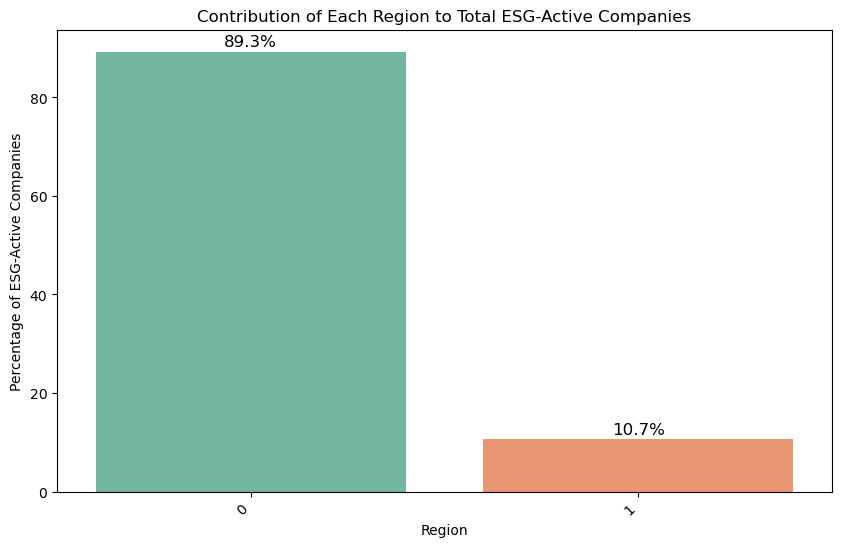

In [58]:
target_counts = ml_df['ESG_any'].value_counts(normalize=True) * 100
plt.figure(figsize=(10, 6))
sns.barplot(x=target_counts.index, y=target_counts.values, palette="Set2")
plt.xticks(rotation=45, ha='right')
plt.title('Contribution of Each Region to Total ESG-Active Companies')
plt.ylabel('Percentage of ESG-Active Companies')
plt.xlabel('Region')
for i, v in enumerate(target_counts.values):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=12)

### Relevant comments related to preprocessing:
Despite the dataset being unbalanced (89% of companies have no ESG engagement, 11% do), SMOTE techniques will not be applied because:

- Synthetic data risk: SMOTE generates interpolated data points that do not exist in reality. ESG engagement represents actual corporate actions, so creating “fake” events could compromise the validity of the analysis.

- Small minority class: With only ~11% of companies in the minority class, SMOTE tends to overfit. It generally performs better when the minority class is at least 20–30%.

- Nature of the problem: Even when extending to multi-label or more granular ESG outcomes, generating synthetic data would misrepresent real corporate behavior and distort insights.

**Planned Approach for handling the imbalance:**

- Stratified splits will be used to ensure the training and test sets maintain the same class distribution.

- Accuracy will not be used as a metric due to class imbalance. Alternative metrics such as F1-score, precision, recall, or ROC-AUC will be preferred.

- This preserves the true structure of the data while guiding model evaluation appropriately.



In [70]:
ml_df.to_parquet('esg_2024', index=False)